(Ensembling_Strategies)=
# Ensemble methods

Ensemble methods consist in training multiple prediction models for the same prediction task, and in combining their outputs to make the final prediction {cite}`fernandez2018learning,haixiang2017learning,bontempi2021statistical`. Ensembles of models very often allow to provide better prediction performances than single models, since combining the predictions from multiple models usually allows to reduce the overfitting phenomenon. The prediction models making up an ensemble are referred to as *baseline learners*. Both the way with which the baseline learners are constructed and how their predictions are combined are key factors in the design of an ensemble {cite}`fernandez2018learning,bontempi2021statistical,friedman2001elements`.

Ensemble methods can be broadly divided into *parallel-based* and *iterative-based* ensembles {cite}`haixiang2017learning`. In parallel-based ensembles, each baseline learner is trained in parallel, using either a subset of the training data, a subset of the training features, or a combination of both. The two most popular techniques for parallel-based ensembles are *bagging* {cite}`breiman1996bagging` and *random forest* {cite}`breiman2001random`. In iterative-based ensembles, also referred to as *boosting* {cite}`friedman2001elements,freund1997decision`, the baseline classifiers are trained in sequence, with each learner in the sequence aiming at minimizing the prediction errors of the previous learner. The currently most widely-used implementations for boosting are XGBoost {cite}`chen2016xgboost`, CatBoost {cite}`dorogush2018catboost` and LightGBM {cite}`ke2017lightgbm`. 

The ability of ensemble methods to improve prediction performances was illustrated in the previous chapter (see Sections [](Model_Selection_Comparison_Performances) and [](Model_Selection_RWD_Comparison)). In particular, our experimental comparison showed that random forests and XGBoost allowed to significantly improve the AUC ROC and Average Precision compared to decision trees and logistic regression.

This section takes a more specific look at ensemble methods in the context of imbalanced data. A common strategy when dealing with ensembles and imbalanced data is to use a different sampling of the training set for the training of the baseline learners. The procedure is illustrated in Fig. 1 for parallel-based ensembles. A first stage of resampling may aim at rebalancing samples by either oversampling the minority class, undersampling the majority class, or both. In a second stage, the number of features may also be sampled before proceeding to the training of baseline learners {cite}`haixiang2017learning,fernandez2018learning`.  

![alt text](images/parallel_based_framework.png)
```{div} caption-figure 
Fig. 1. Parallel-based framework in the context of imbalanced data. Sampling strategies may be applied at the level of samples or features (or both) before training the baseline classifiers {cite}`haixiang2017learning`. 
```

[Cost-sensitive learning techniques](Cost_Sensitive_Learning) may also be used together with resampling techniques by weighting the classes during the training of the baseline learners. Ensemble methods therefore provide a very flexible framework, where all of the techniques presented in the two previous sections can be used, but also combined with different types of baseline learners. 

The diversity of possible approaches is illustrated in this section by discussing three different ensemble methods for imbalanced learning: Balanced bagging {cite}`maclin1997empirical`, balanced random forest {cite}`chen2004using`, and weighted XGBoost {cite}`chen2016xgboost`.  


In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py
#%run ../Chapter_References/shared_functions.ipynb

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed
   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63060  100 63060    0     0   144k      0 --:--:-- --:--:-- --:--:--  145k


## Illustrative example

Let us first consider the simple classification task presented in [the previous section](Imbalanced_Learning_Illustrative_Example).

In [2]:
X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                            n_redundant=0, n_repeated=0, n_classes=2,
                                            n_clusters_per_class=1,
                                            weights=[0.95, 0.05],
                                            class_sep=0.5, random_state=0)

dataset_df = pd.DataFrame({'X1':X[:,0],'X2':X[:,1], 'Y':y})


In [3]:
%%capture
fig_distribution, ax = plt.subplots(1, 1, figsize=(5,5))

groups = dataset_df.groupby('Y')
for name, group in groups:
    ax.scatter(group.X1, group.X2, edgecolors='k', label=name,alpha=1,marker='o')
    
ax.legend(loc='upper left', 
          bbox_to_anchor=(1.05, 1),
          title="Class")

The dataset contains 5000 samples with two classes, labeled 0 and 1. 95% of the samples are associated to the class 0, and 5% of the samples to the class 1. 

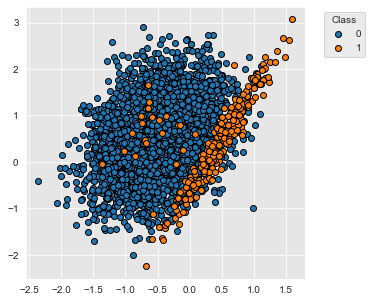

In [4]:
fig_distribution


### Bagging

Bagging relies on the concept of *bootstrap aggregating*, which consists of training several baseline learners with different replicas of the original training set {cite}`breiman1996bagging`. The most usual practice is to randomly draw, with replacement, instances from the original dataset. The dataset size is maintained, meaning that approximately 63.2% of the instances are present in each sample (and some instances appear more than once) {cite}`fernandez2018learning`.

The standard Python implementation for bagging is provided as part of the `sklearn` library, with the [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) object. Following the same methodology as in the previous sections, let us train a bagging classifier, assess its performances, and plot the resulting decision boundary. We use for this example decision trees of depth 5 as the baseline learners, and build an ensemble of 100 trees.  

In [5]:
%%capture
classifier = sklearn.ensemble.BaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=5,random_state=0),
                                                n_estimators=100,
                                                bootstrap=True,
                                                random_state=0)


(results_df_bagging, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                 X, y, 
                                                                                 n_splits=5,
                                                                                 strategy_name="Bagging")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [6]:
results_df_bagging

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.287+/-0.002,0.018+/-0.001,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041


The classification performances of this bagging classifier are better than those of a single decision tree (see [baseline results in cost-sensitive larning](Imbalanced_Learning_Illustrative_Example)) for AUC ROC and Average Precision but lower in terms of balanced accuracy. 

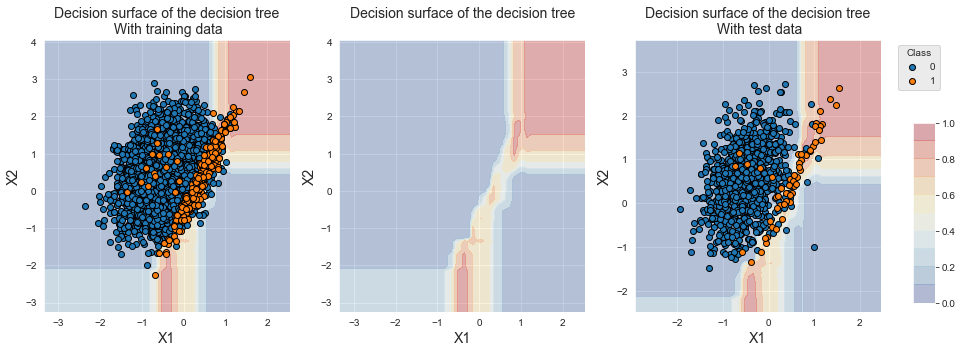

In [7]:
fig_decision_boundary

Compared to a single decision tree, the decision boundary is more refined. Most of the samples lying on the overlapping region are however classified into the majority class due to the imbalanced nature of the dataset.

#### Balanced Bagging

Balanced bagging {cite}`maclin1997empirical` follows the same strategy as bagging, except that the training data is resampled using imbalanced learning techniques. An implementation of balanced bagging is provided by the [`BalancedBaggingClassifier`](https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.BalancedBaggingClassifier.html) object of the `imblearn` library. The type of sampler and desired imbalance ratio are set with the `sampler` and `sampling_strategy` parameters, respectively. The default parameters consist of using a random undersampler and an imbalance ratio of 1, which means that samples from the majority class are randomly removed until their number equals that of the minority class (see Section [](Resampling_Strategies_Undersampling)). 

Let us train an ensemble of decision trees using a `BalancedBaggingClassifier` with its default parameters, and assess its performances and decision boundary. 

In [11]:
%%capture
classifier = imblearn.ensemble.BalancedBaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=5,random_state=0),
                                                         n_estimators=100,
                                                         sampling_strategy=1,
                                                         bootstrap=True,
                                                         sampler=imblearn.under_sampling.RandomUnderSampler(),
                                                         random_state=0)


(results_df_balanced_bagging, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                          X, y, 
                                                                                          n_splits=5,
                                                                                          strategy_name="Balanced bagging")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [13]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging])


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.287+/-0.002,0.018+/-0.001,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.225+/-0.014,0.02+/-0.0,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013


The resulting performances are similar to bagging in terms of AUC ROC and Average Precision. The balanced accuracy is however much higher with balanced bagging. This results from the shift of the decision boundary towards the region that contains the minority class, as is illustrated below. 

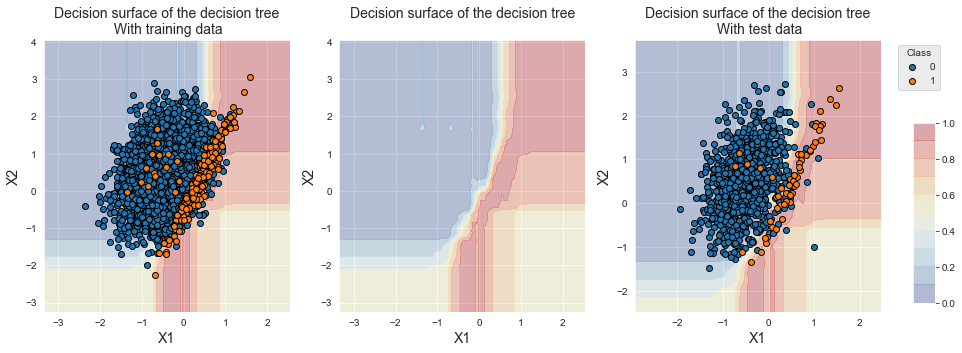

In [14]:
fig_decision_boundary

It is worth noting that the bottom right region is now associated with the minority class. This is due to the random undersampling, as was already observed in the [previous section](Resampling_Strategies_RUS) with a single decision tree.  

###  Random forest

Random forests were introduced by Breiman in 2001 {cite}`breiman2001random`. They have become one of the most popular ML technique for a wide range of prediction tasks among which fraud detection {cite}`priscilla2019credit,haixiang2017learning`. 

A random forest is an ensemble of decision trees, where each tree is built using a random subset of the training data. The method is therefore closely related to bagging. The main difference lies in the building of the decision trees, where splitting is done using only a random subset of the features. This additional random variation has beneficial consequences. First, it usually leads to better predictive performances thanks to a higher diversity in the tree structures, lower overfitting, and higher robustness to noise and outliers. Second, it also speeds up the computation times since fewer features are considered in the construction of the trees {cite}`breiman2001random`. 

The random forest procedure is provided in Python `sklearn` by the [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) object. The main parameters are the maximum tree depth and the number of trees, which are set with the `max_depth` and `n_estimators` parameters, respectively. 

Let us train a random forest classifier with 100 trees and a maximum depth of 5, and assess its performances and decision boundary. 

In [15]:
%%capture
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=100, 
                                                     max_depth=5,
                                                     random_state=0)

(results_df_rf, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                            X, y, 
                                                                            n_splits=5,
                                                                            strategy_name="Random forest")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [16]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf])


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.287+/-0.002,0.018+/-0.001,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.225+/-0.014,0.02+/-0.0,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.186+/-0.015,0.017+/-0.0,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022


Performances in terms of AUC ROC and Average Precision are similar to bagging, and balanced accuracy slightly lower. The training time is significantly reduced.   

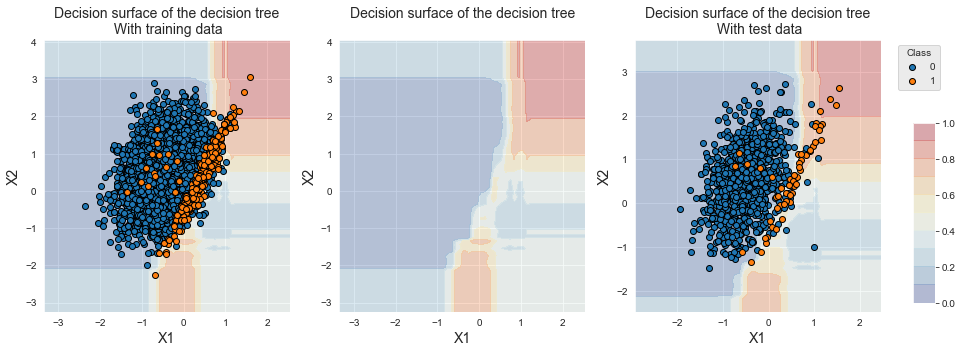

In [17]:
fig_decision_boundary

The decision boundary is also similar to what was obtained with bagging, which reflects the similarity between the two procedures. 

#### Balanced random forest

Balanced random forest was introduced in {cite}`chen2004using` in order to deal with imbalanced data. The procedure follows the same rationale as balanced bagging, and consists in building the baseline learners with balanced training sets. The procedure is implemented with the [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html) object of the Python `imblearn` library.

The `sampling_strategy` parameter determines the imbalance ratio of the training sets used to build the decision trees. Let us train a balanced random forest classifier with 100 trees, a maximum depth of 5, and an imbalance ratio of 1, and assess its performances and decision boundary. 

In [18]:
%%capture
classifier = imblearn.ensemble.BalancedRandomForestClassifier(n_estimators=100, 
                                                              sampling_strategy=1,
                                                              max_depth=5,
                                                              random_state=0)

(results_df_rf_balanced, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                     X, y, 
                                                                                     n_splits=5,
                                                                                     strategy_name="Balanced random forest")


fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


The resulting performances are on par with balanced bagging. 

In [19]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf,
           results_df_rf_balanced])


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.287+/-0.002,0.018+/-0.001,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.225+/-0.014,0.02+/-0.0,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.186+/-0.015,0.017+/-0.0,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022
Balanced random forest,0.19+/-0.014,0.018+/-0.0,0.946+/-0.01,0.58+/-0.083,0.916+/-0.014


We note that the training procedure is faster than balanced bagging.

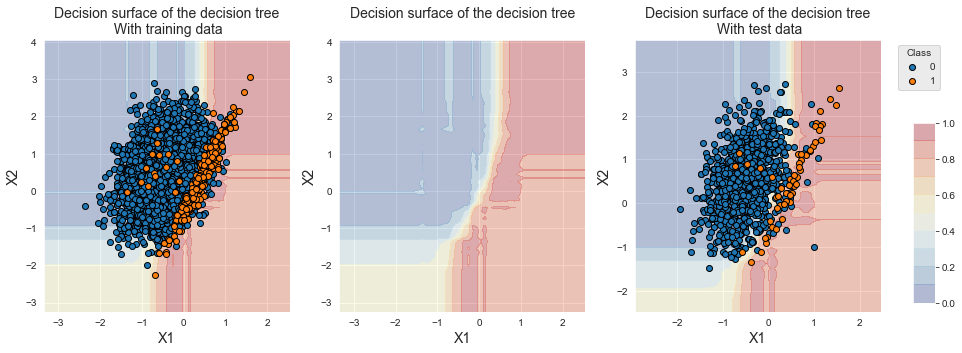

In [20]:
fig_decision_boundary

Similar to balanced bagging, we also note that the decision boundary is shifted towards the minority class and that the bottom right region is associated with the minority class.

### XGBoost

XGBoost stands for *extreme gradient boosting* and is one of the most efficient ensemble techniques in machine learning. It was shown to provide state-of-the-art results in a range of machine learning benchmarks as well as in Kaggle competitions {cite}`bentejac2021comparative,chen2016xgboost`. 

XGBoost provides a scalable implementation of gradient tree boosting {cite}`friedman2001greedy`. The implementation details go beyond the scope of this book, and we refer the reader to {cite}`chen2016xgboost` for the description of the algorithm and its optimization. 

The Python implementation is provided by the [`XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) object of the `XGBoost` library. XGBoost features many tuning parameters, the most important ones being the number of boosting rounds `n_estimators`, the maximum tree depth of the base learners `max_depth`, and the learning rate `learning rate`. 

Let us train an XGBoost classifier and assess its performances and decision boundary. We use in the following the default parameters, which consist of 100 boosting rounds, a maximum tree depth of 6, and a learning rate of 0.3.

In [21]:
%%capture
classifier = xgboost.XGBClassifier(n_estimators=100,
                                   max_depth=6,
                                   learning_rate=0.3,
                                   random_state=0)

(results_df_xgboost, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                 X, y, 
                                                                                 n_splits=5,
                                                                                 strategy_name="XGBoost")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


The resulting classifier provides performances that are competitive with those obtained with bagging and random forest. 

In [22]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf,
           results_df_rf_balanced,
           results_df_xgboost])


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.287+/-0.002,0.018+/-0.001,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.225+/-0.014,0.02+/-0.0,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.186+/-0.015,0.017+/-0.0,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022
Balanced random forest,0.19+/-0.014,0.018+/-0.0,0.946+/-0.01,0.58+/-0.083,0.916+/-0.014
XGBoost,0.142+/-0.004,0.007+/-0.0,0.95+/-0.008,0.59+/-0.066,0.772+/-0.04


Let us plot the resulting decision boundary. 

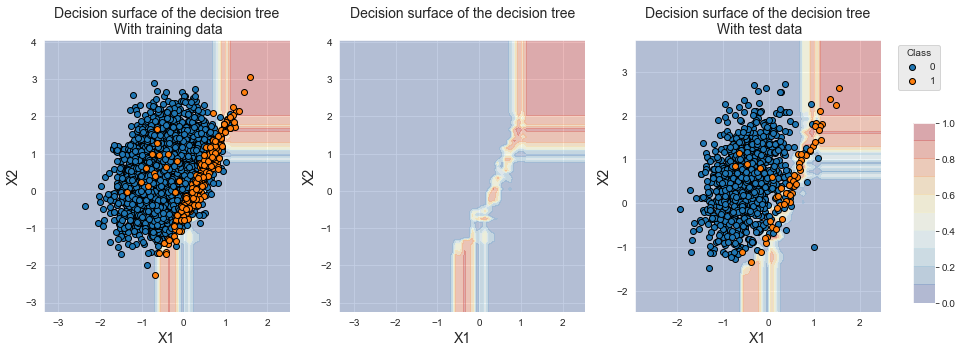

In [19]:
fig_decision_boundary

The decision boundary slightly differs from bagging and random forest. XGBoost more precisely isolates the region containing samples from the minority class.  

#### Weighted XGBoost

Cost-sensitive learning can be applied to XGBoost by means of the `scale_pos_weight` parameter. Assuming that the cost of a false positive is 1, the parameter determines the cost of a false negative. It is worth noting that this parameter is the only one to deal with imbalanced data using XGBoost: contrary to bagging and random forest, XGBoost cannot be combined with resampling techniques.   

Let us use the [imbalance ratio](IR=0.05/0.95 ) to set the class weight. Since there is 5% of samples from the minority class, and 95% of samples from the majority class, the imbalance ratio IR is:


In [20]:
IR=0.05/0.95 
IR

0.052631578947368425

Since `scale_pos_weight` quantifies the cost of a false negative, we set its value to the inverse of the imbalance ratio. 

In [21]:
%%capture
classifier = xgboost.XGBClassifier(n_estimators=100,
                                   max_depth=6,
                                   learning_rate=0.3,
                                   scale_pos_weight=1/IR,
                                   random_state=0)

(results_df_weighted_xgboost, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                          X, y, 
                                                                                          n_splits=5,
                                                                                          strategy_name="Weighted XGBoost")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


Compared to XGBoost, the weighing of false negative allows a slight increase in terms of Average Precision and balanced accuracy and a similar performance in terms of AUC ROC. We note that the balanced accuracy is lower than those obtained with balanced bagging and balanced random forest. 

In [22]:
pd.concat([results_df_bagging, 
           results_df_balanced_bagging,
           results_df_rf,
           results_df_rf_balanced,
           results_df_xgboost,
           results_df_weighted_xgboost])


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Bagging,0.55+/-0.05,0.048+/-0.012,0.943+/-0.01,0.597+/-0.07,0.748+/-0.041
Balanced bagging,0.55+/-0.047,0.052+/-0.009,0.947+/-0.01,0.586+/-0.058,0.92+/-0.013
Random forest,0.334+/-0.045,0.04+/-0.002,0.933+/-0.016,0.593+/-0.087,0.672+/-0.022
Balanced random forest,0.445+/-0.081,0.043+/-0.012,0.946+/-0.01,0.58+/-0.083,0.916+/-0.014
XGBoost,0.343+/-0.038,0.013+/-0.002,0.95+/-0.008,0.59+/-0.066,0.772+/-0.04
Weighted XGBoost,0.363+/-0.052,0.01+/-0.001,0.946+/-0.012,0.598+/-0.061,0.855+/-0.021


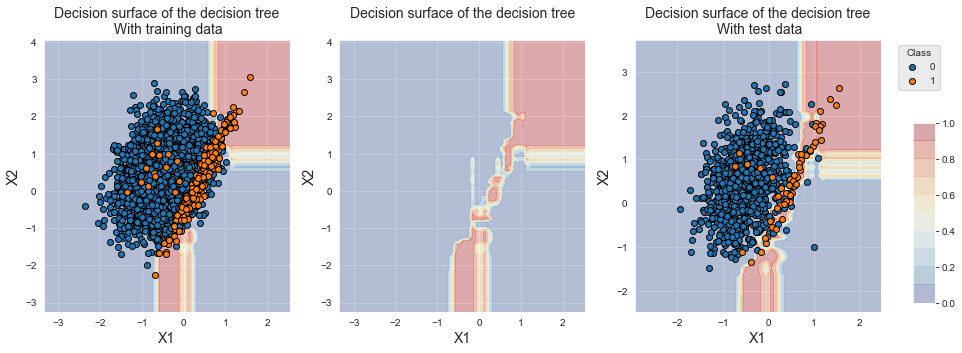

In [23]:
fig_decision_boundary

The decision boundary shows that a larger region is now associated with the minority class. Interestingly, XGBoost does not overfit as much as balanced bagging and balanced random forest. In particular, the bottom right region remains associated with the majority class. 

(Ensembling_Strategies_Transaction_Data)=
## Transaction data

Let us now apply these three ensemble techniques to the simulated dataset of transaction data. We reuse the methodology of [Chapter 5, Model Selection](Model_Selection), using prequential validation as the validation strategy.

### Load data

The loading of data and initialization of the parameters follow the same template as in [Chapter 5, Model Selection](Model_Selection).

In [24]:
# Load data from the 2018-07-11 to the 2018-09-14

DIR_INPUT = 'simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }



Load  files
CPU times: user 731 ms, sys: 526 ms, total: 1.26 s
Wall time: 1.31 s
919767 transactions loaded, containing 8195 fraudulent transactions


(Ensembling_Strategies_Transaction_Data_Baseline)=
### Baseline

Let us first assess the performances of bagging, random forest, and XGBoost without imbalanced learning techniques. We refer to these performances as *baseline* performances. 

The hyperparameters are chosen as follows:

* Bagging and random forest: 100 trees, with a maximum depth of 20. These were shown to provide the best performances for random forests in [Chapter 5, Model Selection - Random forest](Model_Selection_Random_Forest).
* XGBoost: 50 trees, with a maximum depth of 3, and a learning rate of 0.3. These were shown to provide the best trade-off in terms of performances in [Chapter 5, Model Selection - XGBoost](Model_Selection_XGBoost). 



In [25]:
#### Bagging
# Define classifier
classifier = sklearn.ensemble.BaggingClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__base_estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__bootstrap':[True],
              'clf__n_estimators':[100],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_bagging = time.time()-start_time

# Select parameter of interest (n_estimators)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

# Rename to performances_df_baseline_bagging for model performance comparison later in this section
performances_df_baseline_bagging=performances_df

In [26]:
summary_performances_baseline_bagging=get_summary_performances(performances_df_baseline_bagging, parameter_column_name="Parameters summary")
summary_performances_baseline_bagging

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100,100,100
Validation performance,0.872+/-0.01,0.704+/-0.01,0.284+/-0.01
Test performance,0.856+/-0.02,0.678+/-0.01,0.293+/-0.01
Optimal parameter(s),100,100,100
Optimal test performance,0.856+/-0.02,0.678+/-0.01,0.293+/-0.01


In [27]:
#### Random forest
# Define classifier
classifier = sklearn.ensemble.RandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[100],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_rf = time.time()-start_time

# Select parameter of interest (n_estimators)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

# Rename to performances_df_baseline_rf for model performance comparison later in this section
performances_df_baseline_rf=performances_df

In [28]:
summary_performances_baseline_rf=get_summary_performances(performances_df_baseline_rf, parameter_column_name="Parameters summary")
summary_performances_baseline_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100,100,100
Validation performance,0.88+/-0.01,0.694+/-0.02,0.289+/-0.02
Test performance,0.87+/-0.02,0.678+/-0.01,0.299+/-0.01
Optimal parameter(s),100,100,100
Optimal test performance,0.87+/-0.02,0.678+/-0.01,0.299+/-0.01


In [29]:
#### XGBoost
# Define classifier
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3], 
              'clf__n_estimators':[50],
              'clf__learning_rate':[0.3],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_xgboost = time.time()-start_time

# Select parameter of interest (n_estimators)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

# Rename to performances_df_baseline_xgboost for model performance comparison later in this section
performances_df_baseline_xgboost=performances_df

In [30]:
summary_performances_baseline_xgboost=get_summary_performances(performances_df_baseline_xgboost, parameter_column_name="Parameters summary")
summary_performances_baseline_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50,50,50
Validation performance,0.883+/-0.01,0.708+/-0.02,0.288+/-0.02
Test performance,0.872+/-0.01,0.687+/-0.01,0.302+/-0.01
Optimal parameter(s),50,50,50
Optimal test performance,0.872+/-0.01,0.687+/-0.01,0.302+/-0.01


The baseline performances are reported in the table below. It is worth noting that the performances for random forest and XGBoost are the same as those reported in [Chapter 5, Model Selection - Random forest](Model_Selection_Random_Forest) and [Chapter 5, Model Selection - XGBoost](Model_Selection_XGBoost), respectively.

In [31]:
summary_test_performances = pd.concat([summary_performances_baseline_bagging.iloc[2,:],
                                       summary_performances_baseline_rf.iloc[2,:],
                                       summary_performances_baseline_xgboost.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline Bagging', 'Baseline RF', 'Baseline XGBoost']
summary_test_performances

,Baseline Bagging,Baseline RF,Baseline XGBoost
AUC ROC,0.856+/-0.02,0.87+/-0.02,0.872+/-0.01
Average precision,0.678+/-0.01,0.678+/-0.01,0.687+/-0.01
Card Precision@100,0.293+/-0.01,0.299+/-0.01,0.302+/-0.01


XGBoost provides slightly higher Average Precision than random forest and bagging. Bagging provides slightly lower AUC ROC and CP@100 than random forest and XGBoost. Overall, the three ensemble strategies achieve similar performances.

(Ensembling_Strategies_Transaction_Data_Bagging)=
### Balanced bagging

Keeping the same hyperparameters as above (100 trees with a maximum depth of 20), let us assess the ability of balanced bagging to improve classification performances. We rely on random undersampling, which is the default sampler. The imbalance ratio (`sampling_strategy` parameter) is parametrized to take values in the set $[0.02, 0.05, 0.1, 0.5, 1]$ for the model selection procedure.    


In [32]:
# Define classifier
classifier = imblearn.ensemble.BalancedBaggingClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__base_estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.02, 0.05, 0.1, 0.5, 1], 
              'clf__bootstrap':[True],
              'clf__sampler':[imblearn.under_sampling.RandomUnderSampler()],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_balanced_bagging = time.time()-start_time



In [33]:
# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

# Rename to performances_df_balanced_bagging for model performance comparison later in this section
performances_df_balanced_bagging=performances_df

In [34]:
performances_df_balanced_bagging

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.869210,0.020009,0.679963,0.011158,0.298571,0.010051,{'clf__base_estimator': DecisionTreeClassifier...,25.338472,0.875647,0.009589,0.704491,0.014563,0.287143,0.014604,0.02
1,0.875633,0.018670,0.679319,0.007153,0.301071,0.010369,{'clf__base_estimator': DecisionTreeClassifier...,9.595980,0.877413,0.008182,0.700732,0.017898,0.286786,0.015856,0.05
2,0.876615,0.016223,0.676736,0.008302,0.304643,0.010369,{'clf__base_estimator': DecisionTreeClassifier...,7.298806,0.878204,0.002966,0.699331,0.018432,0.289286,0.015698,0.10
3,0.878820,0.013479,0.652480,0.021308,0.305357,0.012387,{'clf__base_estimator': DecisionTreeClassifier...,3.528260,0.880359,0.004692,0.657772,0.022306,0.287857,0.017800,0.50
4,0.877182,0.013837,0.631045,0.029855,0.301786,0.012592,{'clf__base_estimator': DecisionTreeClassifier...,4.901024,0.877335,0.003365,0.643261,0.022129,0.289286,0.017098,1.00


Let us summarize the performances to highlight the optimal imbalance ratios.

In [35]:
summary_performances_balanced_bagging = get_summary_performances(performances_df_balanced_bagging, parameter_column_name="Parameters summary")
summary_performances_balanced_bagging

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.5,0.02,0.1
Validation performance,0.88+/-0.0,0.704+/-0.01,0.289+/-0.02
Test performance,0.879+/-0.01,0.68+/-0.01,0.305+/-0.01
Optimal parameter(s),0.5,0.02,0.5
Optimal test performance,0.879+/-0.01,0.68+/-0.01,0.305+/-0.01


We note conflicting results, as the optimal imbalance ratio depends on the performance metric. For better visualization, let us plot the performances as a function of the imbalance ratio for the three performance metrics.

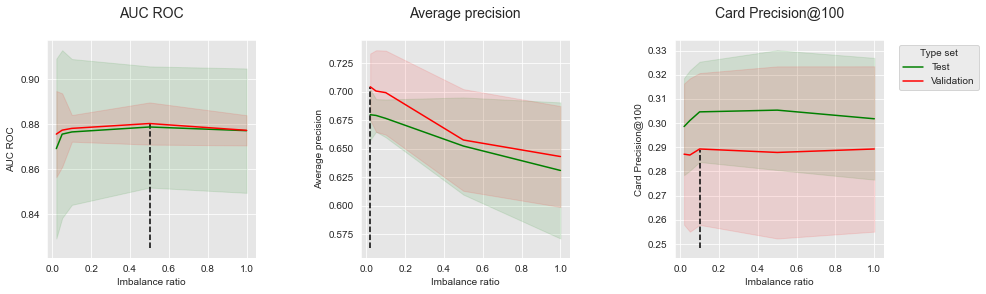

In [36]:
get_performances_plots(performances_df_balanced_bagging, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_balanced_bagging)

Undersampling is clearly detrimental to the Average Precision, where increasing the imbalance ratio leads to a decrease in performance. The highest Average Precision is obtained for an imbalance ratio of 0.02 which is the imbalance ratio of the transaction dataset. A different trend is observed for AUC ROC and CP@100 where increasing the imbalance ratio first leads to better performances, before reaching some optimum after which performances decrease. In this experiment, an imbalance ratio of 0.5 is found to be optimal for AUC ROC, while an imbalance ratio of 0.1 provides the best result in terms of CP@100.

Let us finally compare the performances achieved with bagging and balanced bagging. 

In [37]:
summary_test_performances = pd.concat([summary_performances_baseline_bagging.iloc[2,:],
                                       summary_performances_balanced_bagging.iloc[2,:]
                                      ],axis=1)
summary_test_performances.columns=['Baseline Bagging', 'Balanced Bagging']
summary_test_performances

,Baseline Bagging,Balanced Bagging
AUC ROC,0.856+/-0.02,0.879+/-0.01
Average precision,0.678+/-0.01,0.68+/-0.01
Card Precision@100,0.293+/-0.01,0.305+/-0.01


As noted above, balanced bagging allows to improve both AUC ROC and CP@100, but does not appear to improve the Average Precision. 

(Ensembling_Strategies_Transaction_Data_RF)=
### Balanced Random Forest

The same methodology is applied with balanced random forest. The imbalance ratio (`sampling_strategy` parameter) is parametrized to take values in the set $[0.01, 0.05, 0.1, 0.5, 1]$ for the model selection procedure.    


In [38]:
# Define classifier
classifier = imblearn.ensemble.BalancedRandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_rf_balanced = time.time()-start_time



In [39]:
# Select parameter of interest (sampling_strategy)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

# Rename to performances_df_balanced_rf for model performance comparison later in this section
performances_df_balanced_rf=performances_df

In [40]:
performances_df_balanced_rf

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.870357,0.016188,0.676942,0.008811,0.303929,0.011534,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",34.225113,0.880145,0.008573,0.694636,0.019742,0.287857,0.015600,0.01
1,0.872143,0.021075,0.658319,0.017522,0.302500,0.011797,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",8.284223,0.881513,0.002490,0.672938,0.024907,0.290714,0.017971,0.05
2,0.874943,0.016199,0.639242,0.026416,0.302500,0.013716,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",6.776770,0.878352,0.001225,0.659061,0.023005,0.290000,0.016382,0.10
3,0.875914,0.014254,0.601545,0.029253,0.302143,0.013609,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",5.092815,0.879629,0.004810,0.602540,0.022916,0.288929,0.015952,0.50
4,0.871298,0.011698,0.571147,0.032975,0.299643,0.013147,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",5.182013,0.872742,0.005465,0.566056,0.032686,0.279643,0.016732,1.00


Let us summarize the performances to highlight the optimal imbalance ratio, and plot the performances as a function of the imbalance ratio for the three performance metrics.

In [41]:
summary_performances_balanced_rf=get_summary_performances(performances_df=performances_df_balanced_rf, parameter_column_name="Parameters summary")
summary_performances_balanced_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.05,0.01,0.05
Validation performance,0.882+/-0.0,0.695+/-0.02,0.291+/-0.02
Test performance,0.872+/-0.02,0.677+/-0.01,0.302+/-0.01
Optimal parameter(s),0.5,0.01,0.01
Optimal test performance,0.876+/-0.01,0.677+/-0.01,0.304+/-0.01


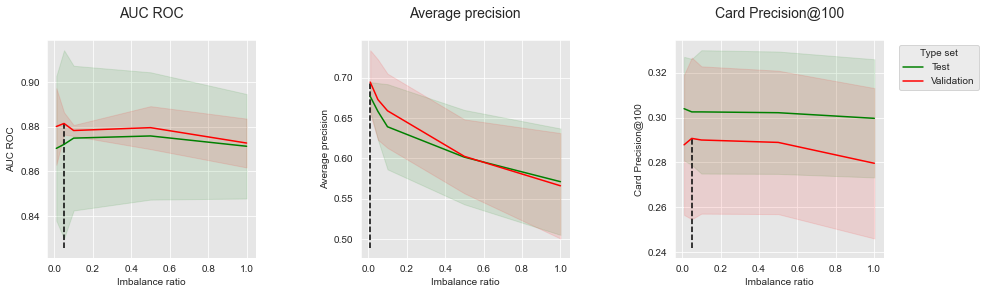

In [42]:
get_performances_plots(performances_df_balanced_rf, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_balanced_rf)

The results are qualitatively similar to balanced bagging. Increasing the imbalance ratio is detrimental to Average Precision, but can lead to marginal performance improvements for AUC ROC and CP@100. The optimum is found for an imbalance ratio of 0.05. 

Let us finally compare the performances achieved with random forest and balanced random forest. 

In [43]:
summary_test_performances = pd.concat([summary_performances_baseline_rf.iloc[2,:],
                                       summary_performances_balanced_rf.iloc[2,:]
                                      ],axis=1)
summary_test_performances.columns=['Baseline RF', 'Balanced RF']
summary_test_performances

,Baseline RF,Balanced RF
AUC ROC,0.87+/-0.02,0.872+/-0.02
Average precision,0.678+/-0.01,0.677+/-0.01
Card Precision@100,0.299+/-0.01,0.302+/-0.01


The performance increase in terms of AUC ROC and CP@100 is only marginal. Overall, the balanced random forest did not allow to improve performances.

(Ensembling_Strategies_Transaction_Data_Weighted_XGBoost)=
### Weighted XGBoost

For weighted XGBoost, the class weight is set with the `scale_pos_weight` parameter. Keeping the same hyperparameters as the baseline XGBoost (50 trees with a maximum depth of 3, and a learning rate of 0.3), we vary the `scale_pos_weight` parameter to take values in the set $[1,5,10,50,100]$. 

In [44]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3], 
              'clf__n_estimators':[50],
              'clf__learning_rate':[0.3],
              'clf__scale_pos_weight':[1,5,10,50,100], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_xgboost = time.time()-start_time


In [45]:
# Select parameter of interest (scale_pos_weight)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__scale_pos_weight'] for i in range(len(parameters_dict))]

# Rename to performances_df_weighted_xgboost for model performance comparison later in this section
performances_df_weighted_xgboost=performances_df

In [46]:
performances_df_weighted_xgboost

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.871726,0.010990,0.686534,0.011086,0.302143,0.013458,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",6.617693,0.882839,0.008380,0.708226,0.020697,0.287500,0.016331,1
1,0.866154,0.008993,0.667997,0.004161,0.300000,0.010351,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",6.618995,0.882704,0.010765,0.697100,0.021795,0.288571,0.013477,5
2,0.865940,0.008009,0.667121,0.007867,0.298214,0.008534,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",7.350666,0.880610,0.005834,0.691400,0.018352,0.287500,0.014996,10
3,0.863178,0.007149,0.648028,0.012585,0.296429,0.011316,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",6.550463,0.882049,0.011948,0.677362,0.021367,0.284643,0.014406,50
4,0.858011,0.006991,0.630036,0.020288,0.292143,0.015403,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",6.716424,0.880666,0.012492,0.661458,0.020015,0.285000,0.016736,100


Let us summarize the performances to highlight the optimal class weights, and plot the performances as a function of the class weight for the three performance metrics.

In [47]:
summary_performances_weighted_xgboost=get_summary_performances(performances_df=performances_df_weighted_xgboost, parameter_column_name="Parameters summary")
summary_performances_weighted_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1,1,5
Validation performance,0.883+/-0.01,0.708+/-0.02,0.289+/-0.01
Test performance,0.872+/-0.01,0.687+/-0.01,0.3+/-0.01
Optimal parameter(s),1,1,1
Optimal test performance,0.872+/-0.01,0.687+/-0.01,0.302+/-0.01


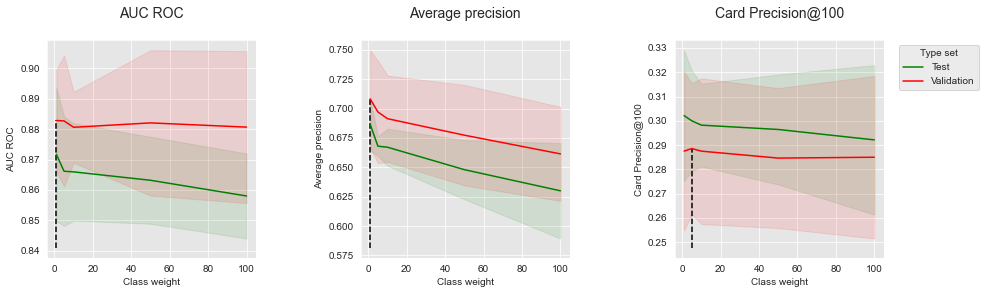

In [48]:
get_performances_plots(performances_df_weighted_xgboost, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Class weight",
                       summary_performances=summary_performances_weighted_xgboost)

The results show that for all metrics, increasing the class weight leads to a decrease in performances on the test set. The best class weight is therefore 1, that is, an equal weight for the minority and the majority class. 

In [49]:
summary_test_performances = pd.concat([summary_performances_baseline_xgboost.iloc[2,:],
                                       summary_performances_weighted_xgboost.iloc[2,:]
                                      ],axis=1)
summary_test_performances.columns=['Baseline XGBoost', 'Weighted XGBoost']
summary_test_performances

,Baseline XGBoost,Weighted XGBoost
AUC ROC,0.872+/-0.01,0.872+/-0.01
Average precision,0.687+/-0.01,0.687+/-0.01
Card Precision@100,0.302+/-0.01,0.3+/-0.01


The performances obtained with weighted XGBoost are therefore the same as those obtained with our baseline.   

(Ensembling_Strategies_Transaction_Data_Summary)=
## Summary 

Let us finally summarize in a single table the results on the dataset of simulated transactions. Performance metrics are reported row-wise, while ensemble methods are reported column-wise. 

In [50]:
summary_test_performances = pd.concat([summary_performances_baseline_bagging.iloc[2,:],
                                       summary_performances_balanced_bagging.iloc[2,:],
                                       summary_performances_baseline_rf.iloc[2,:],
                                       summary_performances_balanced_rf.iloc[2,:],
                                       summary_performances_baseline_xgboost.iloc[2,:],
                                       summary_performances_weighted_xgboost.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline Bagging', 'Balanced Bagging', 
                                   'Baseline RF', 'Balanced RF', 
                                   'Baseline XGBoost', 'Weighted XGBoost']


In [51]:
summary_test_performances

,Baseline Bagging,Balanced Bagging,Baseline RF,Balanced RF,Baseline XGBoost,Weighted XGBoost
AUC ROC,0.856+/-0.02,0.879+/-0.01,0.87+/-0.02,0.872+/-0.02,0.872+/-0.01,0.872+/-0.01
Average precision,0.678+/-0.01,0.68+/-0.01,0.678+/-0.01,0.677+/-0.01,0.687+/-0.01,0.687+/-0.01
Card Precision@100,0.293+/-0.01,0.305+/-0.01,0.299+/-0.01,0.302+/-0.01,0.302+/-0.01,0.3+/-0.01


The best improvements were obtained for balanced bagging, which allowed to improve the bagging performances both in terms of AUC ROC and CP@100. These improvements are likely due to a higher diversity of trees in balanced bagging, stemming from the random sampling of the training set, and leading to less overfitting in the resulting ensemble. 

Little or no improvements were however observed for balanced random forest and weighted XGBoost. These results illustrate that random forest and XGBoost are particularly robust to imbalanced data and overfitting. 

Overall, the experimental results reported in this section do not provide remarkable improvements over the baseline ensembles. These results should however not lead to the conclusion that combining ensemble methods with imbalanced learning techniques has little benefit. Rather, they show that (i) ensemble methods like random forest and XGBoost provide baselines that are difficult to improve, (ii) imbalanced learning techniques do change the decision boundary of the resulting classifier, and (iii) imbalanced learning techniques might improve the predictive performances depending on which performance metric is used.       

## Saving of results

Let us finally save the performance results and execution times.

In [52]:
performances_df_dictionary={
    "Baseline Bagging": performances_df_baseline_bagging,
    "Baseline RF": performances_df_baseline_rf,
    "Baseline XGBoost": performances_df_baseline_xgboost,
    "Balanced Bagging": performances_df_balanced_bagging,
    "Balanced RF": performances_df_balanced_rf,
    "Weighted XGBoost": performances_df_weighted_xgboost
}

execution_times=[execution_time_baseline_bagging,
                 execution_time_baseline_rf,
                 execution_time_baseline_xgboost,
                 execution_time_balanced_bagging,
                 execution_time_rf_balanced,
                 execution_time_weighted_xgboost
                 ]

In [53]:
filehandler = open('performances_ensembles.pkl', 'wb') 
pickle.dump((performances_df_dictionary, execution_times), filehandler)
filehandler.close()